# ANPR SYSTEM FOR EUROPEAN LICENSE PLATES

#### Import all the dependencies

In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import easyocr
from itertools import chain

2021-10-08 11:47:10.877007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-08 11:47:10.877041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Setup paths

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

# Load the trained model

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

2021-10-08 11:47:15.164560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-08 11:47:15.164591: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-08 11:47:15.164613: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dr32): /proc/driver/nvidia/version does not exist
2021-10-08 11:47:15.164836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Perform Number Plate Detection

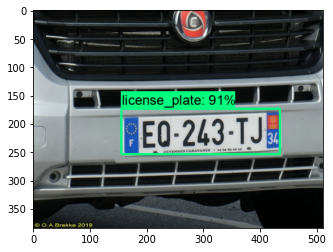

In [15]:
def detect_plate(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'number_plates', '6.jpg')

# Detect license plate from images
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
try:
    detections = detect_plate(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.2,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

except ValueError:
    print("Image not found!")

In [5]:
def removenestedlists(extracted_list):
    '''function for simplifying the text extracted from ocr (removing nested lists)'''
    for i in extracted_list:
        if type(i) == list:
            removenestedlists(i)
        else:
            output_list.append(i)

## Number Plate Reading from Detected Plate

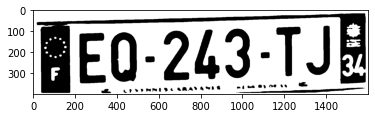

Using CPU. Note: This module is much faster with a GPU.


Overall Details on the detected plate:
EO243-TJ
P3


In [16]:
detection_threshold = 0.2
image = image_np_with_detections
scores = list(filter(lambda x: x >= detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

width = image.shape[1]
height = image.shape[0]

# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    roi = box*[height, width, height, width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    resize_width = 1600
    resize_height = 400
    region = cv2.resize(region, (resize_width, resize_height))

blackAndWhite = cv2.imwrite("image.jpg", region)
blackAndWhite = cv2.imread("image.jpg", 0)

_, blackAndWhite = cv2.threshold(blackAndWhite, 127, 255, cv2.THRESH_BINARY_INV)
os.remove("image.jpg")
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(blackAndWhite, None, None, None, 8, cv2.CV_32S)
sizes = stats[1:, -1] #get CC_STAT_AREA component
image2 = np.zeros((labels.shape), np.uint8)

for i in range(0, nlabels - 1):
    if sizes[i] >= 50:   #filter small dotted regions
        image2[labels == i + 1] = 255
result = cv2.bitwise_not(image2)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

reader = easyocr.Reader(['en'], gpu = False)
ocr_result = reader.readtext(result)
output_list = []
# convert the extracted text into list of lists
extracted_list = list(chain(*ocr_result))

# convert the nested list into a single list
removenestedlists(extracted_list)
print("Overall Details on the detected plate:")
for element0 in output_list:
    if type(element0) == str:
        print(element0.upper())

# Read Middle Portion Of The Plate

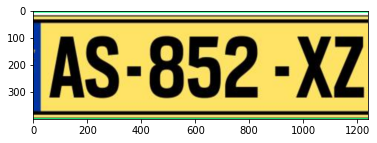

The Car Number is:
AS-852 -XZ


In [7]:
middle_portion = region[0:resize_height, 180:resize_width-180]
plt.imshow(cv2.cvtColor(middle_portion, cv2.COLOR_BGR2RGB))
plt.show()

ocr_result = reader.readtext(middle_portion)
output_list = []
# convert the extracted text into list of lists
extracted_list = list(chain(*ocr_result))

# convert the nested list into a single list
removenestedlists(extracted_list)
print("The Car Number is:")
for element1 in output_list:
    if type(element1) == str:
        print(element1.upper())

# Read Left Portion Of The Plate

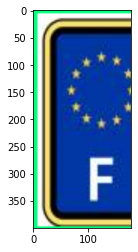

The details written on left side of the number plate:
F


In [8]:
left_portion = region[0:resize_height, 0:180]
ocr_result = reader.readtext(left_portion)
plt.imshow(cv2.cvtColor(left_portion, cv2.COLOR_BGR2RGB))
plt.show()

output_list = []
# convert the extracted text into list of lists
extracted_list = list(chain(*ocr_result))

# convert the nested list into a single list
removenestedlists(extracted_list)
print("The details written on left side of the number plate:")
for element2 in output_list:
    if type(element2) == str:
        print(element2)

# Read Right Portion Of The Plate

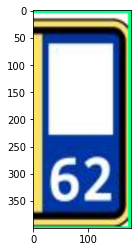

The details written on right side of the number plate:
62


In [9]:
right_portion = region[0:resize_height, resize_width-180:resize_width]
ocr_result = reader.readtext(right_portion)
plt.imshow(cv2.cvtColor(right_portion, cv2.COLOR_BGR2RGB))
plt.show()

output_list = []
# convert the extracted text into list of lists
extracted_list = list(chain(*ocr_result))

# convert the nested list into a single list
removenestedlists(extracted_list)
print("The details written on right side of the number plate:")
for element2 in output_list:
    if type(element2) == str:
        print(element2)

# Real Time Number Plate Detection

In [10]:
video_capture = cv2.VideoCapture(0)
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

while video_capture.isOpened(): 
    ret, frame = video_capture.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_plate(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.2,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == 27:
        video_capture.release()
        cv2.destroyAllWindows()
        break

[ WARN:0] global /tmp/pip-req-build-afu9cjzs/opencv/modules/videoio/src/cap_v4l.cpp (890) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
